In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

In [2]:
column_names = ['order_id', 'activation_time_local', 'country_code', 'store_address', 'final_status', 'payment_status', 'products', 'products_total', 'purchase_total_price']


df = pd.read_csv('project_dataset/python_raw_data/fake_orders_test.csv', header=None, names=column_names)

¿Qué porcentaje de pedidos están subautorizados?

In [6]:
df['order_type'] = df.apply(lambda x: 'Subautorizado' if x['products_total'] < x['purchase_total_price'] else 'Autorizado',axis=1)

orders_sub = (df['order_type'] == 'Subautorizado').sum()
total = len(df)
percentage = (orders_sub/total)*100

print(percentage)

57.58443708609271


¿Qué porcentaje de pedidos se autorizarían correctamente con una autorización incremental (+20%) sobre el monto en el checkout?

In [7]:
df['products_total_incr20'] = df['products_total']*1.20


df['order_type_20'] = df.apply(lambda x: 'Subautorizado' if x['products_total_incr20'] < x['purchase_total_price'] else 'Autorizado',axis=1)

orders_sub_20 = (df['order_type_20'] == 'Subautorizado').sum()

total = len(df)
percentage_20 = (orders_sub_20/total)*100

print(percentage_20)

30.96523178807947


¿Hay diferencias cuando se dividen por país?

In [8]:
subauthorized_counts = df[df['order_type_20'] == 'Subautorizado'].groupby('country_code')

grouped = df.groupby('country_code').agg(
    subauthorized_count=('order_type_20', lambda x: (x == 'Subautorizado').sum()),
    total_count=('order_type_20', 'size')
)

grouped['percentage_subauthorized'] = (grouped['subauthorized_count'] / grouped['total_count']) * 100

print(grouped)

              subauthorized_count  total_count  percentage_subauthorized
country_code                                                            
AR                           4434        13192                 33.611280
BR                              1            2                 50.000000
CI                              2            6                 33.333333
CL                            961         1104                 87.047101
CR                            223         1107                 20.144535
DO                            190          500                 38.000000
EC                            938         2508                 37.400319
EG                            628         1828                 34.354486
ES                           3650        12806                 28.502265
FR                            698         2136                 32.677903
GE                            173          546                 31.684982
GT                            115          567     

In [ ]:
Para el resto de pedidos que quedarían fuera de la autorización incremental, ¿qué valores serían necesarios para capturar el monto restante?

In [42]:
df['monto_necesario'] = np.where(df['products_total_incr20'] - df['purchase_total_price'] < 0,
                                 df['products_total_incr20'] - df['purchase_total_price'], 
                                 0)

# Cambiar el signo de los valores donde monto_necesario es negativo
df.loc[df['monto_necesario'] < 0, 'monto_necesario'] *= -1

print(df['monto_necesario'].sum())

88648.594


¿Qué tiendas son las más problemáticas en términos de pedidos y valor monetario?

In [43]:
canceled_orders = df[df['final_status'] == 'CanceledStatus']
top_stores_cancelled = canceled_orders.groupby('store_address')['order_id'].nunique().nlargest(500)

print(top_stores_cancelled)

store_address
15144    33
28675    33
28671    23
10695    22
29451    20
         ..
14848     3
14878     3
15679     3
15879     3
15882     3
Name: order_id, Length: 500, dtype: int64


In [44]:
top_stores_amount = df.groupby('store_address')['monto_necesario'].sum().nlargest(500)

print(top_stores_amount)

store_address
10264    1777.804
65896     912.070
9855      905.446
9854      751.592
17327     736.160
           ...   
63014      43.448
12787      43.222
31234      43.168
5329       43.040
61620      43.014
Name: monto_necesario, Length: 500, dtype: float64


In [46]:
grouped = canceled_orders.groupby('store_address').agg(
    num_pedidos_cancelados=('order_id', 'nunique'),
    total_monto_necesario=('monto_necesario', 'sum')
).reset_index()

top_5_stores_order = grouped.sort_values(by='num_pedidos_cancelados', ascending=False).head(5)
print(top_5_stores_order)

top_5_stores_amount= grouped.sort_values(by='total_monto_necesario',  ascending=False).head(5)
print(top_5_stores_amount)

      store_address  num_pedidos_cancelados  total_monto_necesario
417           15144                      33                   0.00
712           28675                      33                   3.15
711           28671                      23                   5.25
294           10695                      22                   0.00
1377          50832                      20                   0.00
      store_address  num_pedidos_cancelados  total_monto_necesario
2246          65896                      16                608.946
1474          52914                       4                378.296
2245          65895                       8                254.790
2247          65898                      18                241.358
2714          72250                       2                213.170


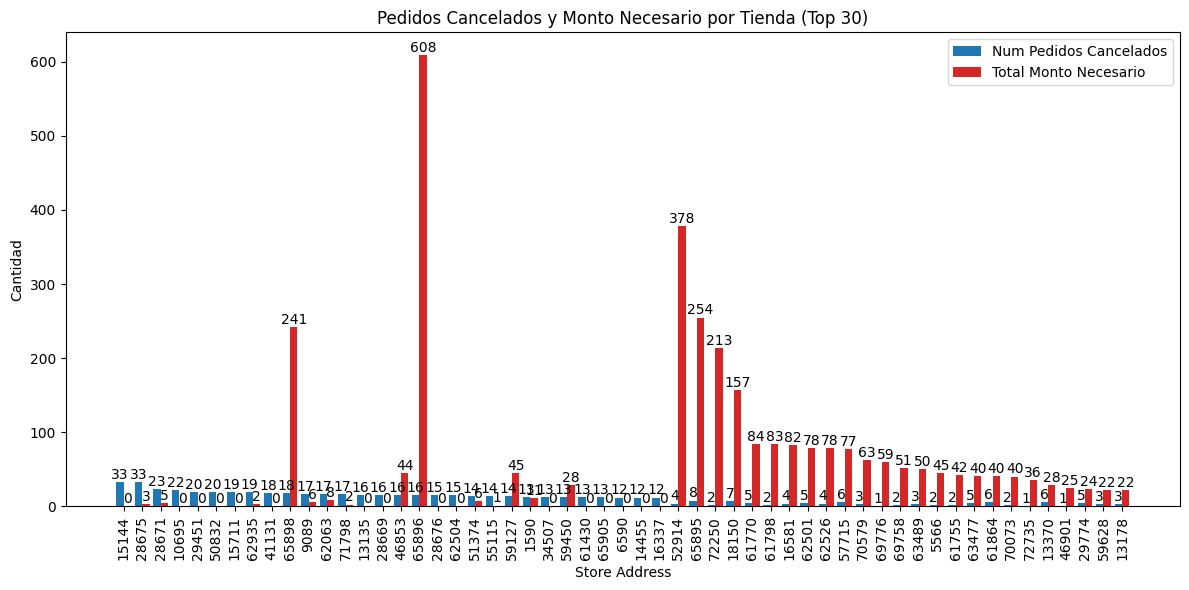

In [47]:
# Seleccionar las 30 tiendas con más pedidos cancelados
top_cancelled = grouped.nlargest(30, 'num_pedidos_cancelados')

# Seleccionar las 30 tiendas con más monto necesario
top_monto = grouped.nlargest(30, 'total_monto_necesario')

# Combinar las tiendas seleccionadas y eliminar duplicados
top_stores = pd.concat([top_cancelled, top_monto]).drop_duplicates().reset_index(drop=True)

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(12, 6))

# Configuración de las barras
width = 0.4
x = np.arange(len(top_stores['store_address']))

# Barras para num_pedidos_cancelados
bars1 = ax.bar(x - width/2, top_stores['num_pedidos_cancelados'], width, label='Num Pedidos Cancelados', color='tab:blue')

# Barras para total_monto_necesario
bars2 = ax.bar(x + width/2, top_stores['total_monto_necesario'], width, label='Total Monto Necesario', color='tab:red')

# Configuración del eje X
ax.set_xlabel('Store Address')
ax.set_xticks(x)
ax.set_xticklabels(top_stores['store_address'], rotation=90)

# Configuración del eje Y
ax.set_ylabel('Cantidad')
ax.set_title('Pedidos Cancelados y Monto Necesario por Tienda (Top 30)')

# Añadir leyenda
ax.legend()

# Añadir etiquetas de datos
for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.1, int(yval), ha='center', va='bottom')

for bar in bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.1, int(yval), ha='center', va='bottom')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [ ]:
Para los pedidos subautorizados, ¿hay una correlación entre la diferencia en los precios y la cancelación del pedido? En otras palabras: ¿Es más probable que se cancele un pedido a medida que aumenta la diferencia de precio?

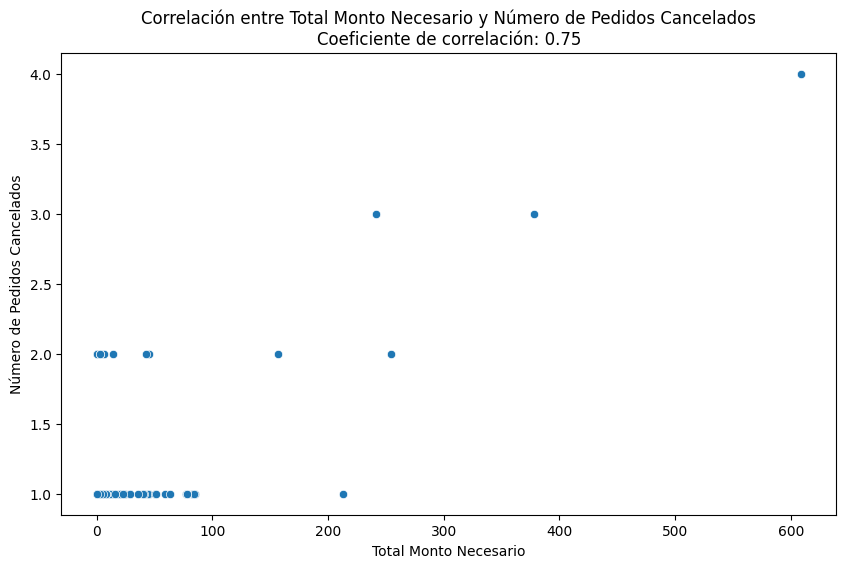

Coeficiente de correlación de Pearson: 0.75
Valor p: 1.05e-34


In [48]:
# Filter the unauthorized and canceled orders
subauth_canceled_orders = df[(df['order_type_20'] == 'Subautorizado') & (df['final_status'] == 'CanceledStatus')]

# Group by store_address and calculate metrics
grouped = subauth_canceled_orders.groupby('store_address').agg(
    total_monto_necesario=('monto_necesario', 'sum'),
    num_pedidos_cancelados=('order_id', 'nunique')
).reset_index()

# Calculate Pearson's correlation coefficient
correlation, p_value = pearsonr(grouped['total_monto_necesario'], grouped['num_pedidos_cancelados'])

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=grouped, x='total_monto_necesario', y='num_pedidos_cancelados')
plt.title(f'Correlación entre Total Monto Necesario y Número de Pedidos Cancelados\nCoeficiente de correlación: {correlation:.2f}')
plt.xlabel('Total Monto Necesario')
plt.ylabel('Número de Pedidos Cancelados')
plt.show()

# Display the correlation coefficient
print(f"Coeficiente de correlación de Pearson: {correlation:.2f}")
print(f"Valor p: {p_value:.2e}")

,store_address,total_monto_necesario,num_pedidos_cancelados
store_address,1.000000,0.145591,0.148472
total_monto_necesario,0.145591,1.000000,0.750143
num_pedidos_cancelados,0.148472,0.750143,1.000000


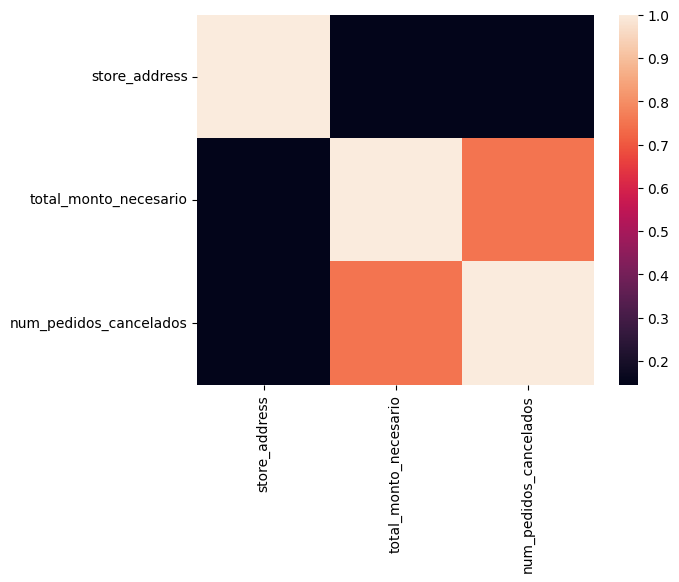

In [50]:
# Calculate the correlation matrix
corr = grouped.corr()
display(corr)
# Create a heatmap to visualize the correlation matrix
sns.heatmap(corr);

In [51]:
#df.to_csv('df_new.csv', index=False)